# Doing the NLP side

This notebook focuses on creating a model to classify the texts.

## Import Libraries

In [1]:
# change the python's path to the parent directory
import sys
sys.path.append("../")

In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.lstm import LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from tools.tools import get_data, load_data, remove_class, tokenize, count_class, calculate_pos_weights
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## Load the data

### Performing Text Cleaning & Data Extraction (Possibly for NLP)

We will see how to code and clean the textual data for the following methods.
- Lowecasing the data
- Removing Puncuatations
- Removing Numbers
- Removing extra space
- Replacing the repetitions of punctations
- Removing Emojis
- Removing emoticons
- Removing Contractions
Reference: https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/

Manual Data Cleaning:
- Remove `\n` character that breaks the caption into two lines (1014.jpg)
- Remove `\n` character that breaks the caption into two lines (2259.jpg)
- Remove `\n` character that breaks the caption into two lines (6751.jpg)
- Remove **a couple of** `\n` character that breaks the caption into two lines (24624.jpg)

**Note: there is no label 12! [Label starts from 1 to 19]**

In [21]:
# import data
train_data = get_data("../dataset/train.csv")
test_data = get_data("../dataset/test.csv")

# perform text cleaning and get the pandas' dataframe
train_data = load_data(train_data)
test_data = load_data(test_data, has_label=False)

# remove an imbalanced class
train_data = remove_class(train_data, class_no=1)

# split into training and validating sets
X = train_data.iloc[:, 0:2]
y = train_data.iloc[:, 2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_test, y_test], axis=1)

# join the data together
for_nlp_data = pd.concat((train_data['caption'], test_data['caption']), ignore_index=True)

In [22]:
train_data['caption']

635      a historical photo of people sitting along sid...
2307     many cars and trucks are traveling down the st...
22910    a green and yellow train pulling into a train ...
17045           a clock sitting int he middle of a walkway
26486           a batter is getting ready to swing the bat
                               ...                        
26122       a couple of men standing around a luggage cart
26615         a plane that is on the ground during the day
7496     a man standing by a dog catching a frisbee on ...
14105    a reflection of someone standing next to a sch...
11854    a white car a blue and white bus a traffic lig...
Name: caption, Length: 12740, dtype: object

In [24]:
val_data['caption']

7222     a building on the side of a street next to a t...
25130    a couple of zebra stnading next to each other ...
22632         a dog is barking at a man sitting on a bench
17002          a man and woman walking past an rd mail box
26849    a dog and a cat are lying next to the sign tha...
                               ...                        
2352       two cars sit at an intersection with crosswalks
29879    a herd of sheep standing next to each other wi...
25754    an aerial view of a train car on tracks in the...
19718    group of cars driving down a downtown area tog...
21161    a riverboat lit up and traveling down a river ...
Name: caption, Length: 3185, dtype: object

In [23]:
test_data['caption']

0       a little girl waring a krispy kreme hat holdin...
1       a beautiful young woman holding an orange frisbee
2       a group of people sitting on couch next to a c...
3               a person on a snowboard rides on the hill
4       a man riding a skateboard with a helmet on in ...
                              ...                        
9995    a group of men riding surfboards riding a mass...
9996    a motorcycle parked next to a car in a parking...
9997              a little boy that is playing with a wii
9998    group of kids play frisbee golf in the middle ...
9999      a man in a gray jacket standing next to a woman
Name: caption, Length: 10000, dtype: object

## Count Vector

In [25]:
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(for_nlp_data)

X_train_vec = vectorizer.transform(train_data['caption'])
X_val_vec = vectorizer.transform(val_data['caption'])
X_test_vec = vectorizer.transform(test_data['caption'])

In [26]:
# the size of vocabulary is 8075
print(X_train_vec.shape)
print(X_val_vec.shape)
print(X_test_vec.shape)

(12740, 6233)
(3185, 6233)
(10000, 6233)


In [27]:
X_train_tensor = torch.from_numpy(X_train_vec.todense()).int()
X_val_tensor = torch.from_numpy(X_val_vec.todense()).int()
X_test_tensor = torch.from_numpy(X_test_vec.todense()).int()

y_train_tensor = torch.from_numpy(np.array(train_data.iloc[:, 2:]))
y_val_tensor = torch.from_numpy(np.array(val_data.iloc[:, 2:]))
y_test_tensor = torch.from_numpy(np.array(test_data.iloc[:, 2:]))

: 

### Instead of using Count Vectorizer, use Tokenization

In [9]:
final_list, vocab = tokenize(for_nlp_data)
X_train_vec = final_list[:train_data.shape[0], :]
X_val_vec = final_list[train_data.shape[0]:train_data.shape[0]+val_data.shape[0], :]
X_test_vec = final_list[train_data.shape[0]:, :]
print(X_train_vec.shape)
print(X_test_vec.shape)
print(len(vocab))

# to tensor
X_train_tensor = torch.from_numpy(X_train_vec).int()
X_test_tensor = torch.from_numpy(X_test_vec).int()

Max Sentence Length: 28
(15925, 28)
(10000, 28)
6488


In [10]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16, 
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_data, 
    batch_size=16, 
    shuffle=False
)

## For Imbalance Data

In [11]:
t_data = get_data("../dataset/train.csv")
t_data = load_data(t_data)
class_counts = list(count_class(t_data).values())
pos_weights = calculate_pos_weights(class_counts, train_data)
if torch.cuda.is_available():
	pos_weights = pos_weights.to('cuda')

## Training the LSTM Model

In [12]:
N_CLASSES = 19

model = LSTM(
    no_layers=2,
    vocab_size=len(vocab), # extra 1 is already included, usually for padding
    embedding_dim=64,
    hidden_dim=256,
    output_dim=19,
)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


In [13]:
BATCH_SIZE = 16
EPOCHS = 100
THRESHOLD = 0.5

clip = 5 # for exploding gradient problem
train_losses = []
train_accs = []
train_f1_scores = []
for epoch in range(EPOCHS):

	# initialize the hidden state
	hidden = model.init_hidden(batch_size=BATCH_SIZE)

	start = 0 # index
	y_true = np.zeros((15925, N_CLASSES))
	y_preds = np.zeros((15925, N_CLASSES))
	train_loss = 0.
	model.train()
	for captions, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			captions = captions.to('cuda')
			labels = labels.to('cuda')

		# creating new variables for the hidden state, otherwise
		# we'd backprop through the entire training history
		hidden = tuple([each.data for each in hidden])

		model.zero_grad()
		y_pred, hidden = model(captions, hidden)

		# backward
		loss = loss_fn(y_pred.squeeze(), labels)
		loss.backward()

		# clip_grad_norm helps prevent the exploding gradient problem in RNNs/LSTMs
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		# update
		optimizer.step()

		# compare
		predicted = (F.sigmoid(y_pred) > THRESHOLD).int()

		n = captions.shape[0]
		y_true[start:start+n] = labels.cpu().numpy()
		y_preds[start:start+n] = predicted.cpu().numpy()
		start = start + n

		train_loss += loss.item()

	train_losses.append(train_loss / len(train_loader))
	train_accs.append(accuracy_score(y_true, y_preds))
	train_f1_scores.append(f1_score(y_true, y_preds, average="macro", zero_division=0.0))

	print("Epoch {:d}".format(epoch+1), end="")
	print(", Train Loss: {:.9f}".format(train_losses[-1]), end="")
	print(", Train Accuracy: {:.7f}%".format(train_accs[-1]*100), end="")
	print(", Train F1 Score: {:.7f}%".format(train_f1_scores[-1]*100))

Epoch 1 Training: 100%|██████████| 996/996 [00:03<00:00, 261.89it/s]


Epoch 1, Train Loss: 1.179404151, Train Accuracy: 0.0000000%, Train F1 Score: 17.7747105%


Epoch 2 Training: 100%|██████████| 996/996 [00:03<00:00, 277.51it/s]


Epoch 2, Train Loss: 1.139322038, Train Accuracy: 0.0000000%, Train F1 Score: 17.7747105%


Epoch 3 Training: 100%|██████████| 996/996 [00:03<00:00, 281.50it/s]


Epoch 3, Train Loss: 1.030850918, Train Accuracy: 0.0000000%, Train F1 Score: 17.7747105%


Epoch 4 Training: 100%|██████████| 996/996 [00:03<00:00, 283.14it/s]


Epoch 4, Train Loss: 1.007425793, Train Accuracy: 0.0000000%, Train F1 Score: 17.7752240%


Epoch 5 Training: 100%|██████████| 996/996 [00:03<00:00, 279.88it/s]


Epoch 5, Train Loss: 0.992869147, Train Accuracy: 0.0000000%, Train F1 Score: 17.8385605%


Epoch 6 Training: 100%|██████████| 996/996 [00:03<00:00, 286.52it/s]


Epoch 6, Train Loss: 0.981510058, Train Accuracy: 0.0000000%, Train F1 Score: 17.9799501%


Epoch 7 Training: 100%|██████████| 996/996 [00:03<00:00, 288.19it/s]


Epoch 7, Train Loss: 0.972124482, Train Accuracy: 0.0000000%, Train F1 Score: 18.1900749%


Epoch 8 Training: 100%|██████████| 996/996 [00:03<00:00, 283.86it/s]


Epoch 8, Train Loss: 0.966163228, Train Accuracy: 0.0000000%, Train F1 Score: 18.2935956%


Epoch 9 Training: 100%|██████████| 996/996 [00:03<00:00, 283.26it/s]


Epoch 9, Train Loss: 0.959777165, Train Accuracy: 0.0000000%, Train F1 Score: 18.6216646%


Epoch 10 Training: 100%|██████████| 996/996 [00:03<00:00, 281.66it/s]


Epoch 10, Train Loss: 0.954339961, Train Accuracy: 0.0000000%, Train F1 Score: 18.8842106%


Epoch 11 Training: 100%|██████████| 996/996 [00:03<00:00, 282.53it/s]


Epoch 11, Train Loss: 0.948910581, Train Accuracy: 0.0000000%, Train F1 Score: 19.2073029%


Epoch 12 Training: 100%|██████████| 996/996 [00:03<00:00, 281.67it/s]


Epoch 12, Train Loss: 0.943047423, Train Accuracy: 0.0000000%, Train F1 Score: 19.5784296%


Epoch 13 Training: 100%|██████████| 996/996 [00:03<00:00, 281.97it/s]


Epoch 13, Train Loss: 0.937952416, Train Accuracy: 0.0000000%, Train F1 Score: 19.8449703%


Epoch 14 Training: 100%|██████████| 996/996 [00:03<00:00, 279.35it/s]


Epoch 14, Train Loss: 0.934795780, Train Accuracy: 0.0000000%, Train F1 Score: 20.0541261%


Epoch 15 Training: 100%|██████████| 996/996 [00:03<00:00, 286.76it/s]


Epoch 15, Train Loss: 0.931820182, Train Accuracy: 0.0000000%, Train F1 Score: 20.5104532%


Epoch 16 Training: 100%|██████████| 996/996 [00:03<00:00, 287.94it/s]


Epoch 16, Train Loss: 0.929807422, Train Accuracy: 0.0000000%, Train F1 Score: 20.8916105%


Epoch 17 Training: 100%|██████████| 996/996 [00:03<00:00, 276.11it/s]


Epoch 17, Train Loss: 0.927602605, Train Accuracy: 0.0000000%, Train F1 Score: 21.4000182%


Epoch 18 Training: 100%|██████████| 996/996 [00:03<00:00, 283.31it/s]


Epoch 18, Train Loss: 0.925453095, Train Accuracy: 0.0000000%, Train F1 Score: 21.8510909%


Epoch 19 Training: 100%|██████████| 996/996 [00:03<00:00, 283.65it/s]


Epoch 19, Train Loss: 0.924020386, Train Accuracy: 0.0000000%, Train F1 Score: 22.7040557%


Epoch 20 Training: 100%|██████████| 996/996 [00:03<00:00, 284.18it/s]


Epoch 20, Train Loss: 0.922097696, Train Accuracy: 0.0000000%, Train F1 Score: 23.2389069%


Epoch 21 Training: 100%|██████████| 996/996 [00:03<00:00, 285.25it/s]


Epoch 21, Train Loss: 0.920845325, Train Accuracy: 0.0000000%, Train F1 Score: 23.8004715%


Epoch 22 Training: 100%|██████████| 996/996 [00:03<00:00, 283.58it/s]


Epoch 22, Train Loss: 0.919817682, Train Accuracy: 0.0000000%, Train F1 Score: 24.6201965%


Epoch 23 Training: 100%|██████████| 996/996 [00:03<00:00, 287.75it/s]


Epoch 23, Train Loss: 0.919237050, Train Accuracy: 0.0000000%, Train F1 Score: 25.1791285%


Epoch 24 Training: 100%|██████████| 996/996 [00:03<00:00, 281.63it/s]


Epoch 24, Train Loss: 0.918609376, Train Accuracy: 0.0000000%, Train F1 Score: 25.9535485%


Epoch 25 Training: 100%|██████████| 996/996 [00:03<00:00, 285.30it/s]


Epoch 25, Train Loss: 0.917407425, Train Accuracy: 0.0000000%, Train F1 Score: 26.7457662%


Epoch 26 Training: 100%|██████████| 996/996 [00:03<00:00, 285.59it/s]


Epoch 26, Train Loss: 0.916973471, Train Accuracy: 0.0062794%, Train F1 Score: 27.2407561%


Epoch 27 Training: 100%|██████████| 996/996 [00:03<00:00, 273.81it/s]


Epoch 27, Train Loss: 0.916751464, Train Accuracy: 0.0000000%, Train F1 Score: 27.2536626%


Epoch 28 Training: 100%|██████████| 996/996 [00:03<00:00, 282.55it/s]


Epoch 28, Train Loss: 0.914511360, Train Accuracy: 0.0062794%, Train F1 Score: 27.6844892%


Epoch 29 Training: 100%|██████████| 996/996 [00:03<00:00, 283.18it/s]


Epoch 29, Train Loss: 0.913571589, Train Accuracy: 0.0062794%, Train F1 Score: 28.4378379%


Epoch 30 Training: 100%|██████████| 996/996 [00:03<00:00, 280.11it/s]


Epoch 30, Train Loss: 0.912761842, Train Accuracy: 0.0125589%, Train F1 Score: 29.3728686%


Epoch 31 Training: 100%|██████████| 996/996 [00:03<00:00, 283.05it/s]


Epoch 31, Train Loss: 0.912248963, Train Accuracy: 0.0439560%, Train F1 Score: 29.8283061%


Epoch 32 Training: 100%|██████████| 996/996 [00:03<00:00, 287.40it/s]


Epoch 32, Train Loss: 0.911987140, Train Accuracy: 0.0502355%, Train F1 Score: 30.6894455%


Epoch 33 Training: 100%|██████████| 996/996 [00:03<00:00, 286.50it/s]


Epoch 33, Train Loss: 0.911416061, Train Accuracy: 0.1381476%, Train F1 Score: 31.3053702%


Epoch 34 Training: 100%|██████████| 996/996 [00:03<00:00, 284.86it/s]


Epoch 34, Train Loss: 0.911523356, Train Accuracy: 0.0376766%, Train F1 Score: 31.3881955%


Epoch 35 Training: 100%|██████████| 996/996 [00:03<00:00, 283.19it/s]


Epoch 35, Train Loss: 0.911437947, Train Accuracy: 0.2009419%, Train F1 Score: 31.9142639%


Epoch 36 Training: 100%|██████████| 996/996 [00:03<00:00, 284.86it/s]


Epoch 36, Train Loss: 0.910837035, Train Accuracy: 0.2386185%, Train F1 Score: 33.1073369%


Epoch 37 Training: 100%|██████████| 996/996 [00:03<00:00, 285.85it/s]


Epoch 37, Train Loss: 0.910141319, Train Accuracy: 0.1632653%, Train F1 Score: 33.4690454%


Epoch 38 Training: 100%|██████████| 996/996 [00:03<00:00, 285.23it/s]


Epoch 38, Train Loss: 0.910102301, Train Accuracy: 0.2888540%, Train F1 Score: 33.7448462%


Epoch 39 Training: 100%|██████████| 996/996 [00:03<00:00, 281.59it/s]


Epoch 39, Train Loss: 0.909671530, Train Accuracy: 0.3202512%, Train F1 Score: 33.6132268%


Epoch 40 Training: 100%|██████████| 996/996 [00:03<00:00, 284.35it/s]


Epoch 40, Train Loss: 0.909517297, Train Accuracy: 0.2135008%, Train F1 Score: 33.8530294%


Epoch 41 Training: 100%|██████████| 996/996 [00:03<00:00, 283.42it/s]


Epoch 41, Train Loss: 0.909442912, Train Accuracy: 0.2009419%, Train F1 Score: 34.4266790%


Epoch 42 Training: 100%|██████████| 996/996 [00:03<00:00, 285.23it/s]


Epoch 42, Train Loss: 0.908804539, Train Accuracy: 0.3139717%, Train F1 Score: 35.6425097%


Epoch 43 Training: 100%|██████████| 996/996 [00:03<00:00, 275.61it/s]


Epoch 43, Train Loss: 0.908948775, Train Accuracy: 0.6593407%, Train F1 Score: 36.2668497%


Epoch 44 Training: 100%|██████████| 996/996 [00:03<00:00, 283.38it/s]


Epoch 44, Train Loss: 0.908891709, Train Accuracy: 0.5337520%, Train F1 Score: 36.5492259%


Epoch 45 Training: 100%|██████████| 996/996 [00:03<00:00, 284.13it/s]


Epoch 45, Train Loss: 0.908947083, Train Accuracy: 0.6279435%, Train F1 Score: 35.8990229%


Epoch 46 Training: 100%|██████████| 996/996 [00:03<00:00, 288.28it/s]


Epoch 46, Train Loss: 0.908744017, Train Accuracy: 0.6467818%, Train F1 Score: 37.1887380%


Epoch 47 Training: 100%|██████████| 996/996 [00:03<00:00, 281.86it/s]


Epoch 47, Train Loss: 0.907865829, Train Accuracy: 0.7284144%, Train F1 Score: 38.3703371%


Epoch 48 Training: 100%|██████████| 996/996 [00:03<00:00, 286.27it/s]


Epoch 48, Train Loss: 0.907548758, Train Accuracy: 1.1679749%, Train F1 Score: 38.8782672%


Epoch 49 Training: 100%|██████████| 996/996 [00:03<00:00, 287.05it/s]


Epoch 49, Train Loss: 0.907852917, Train Accuracy: 0.8100471%, Train F1 Score: 38.3054833%


Epoch 50 Training: 100%|██████████| 996/996 [00:03<00:00, 288.36it/s]


Epoch 50, Train Loss: 0.907695857, Train Accuracy: 0.8916797%, Train F1 Score: 37.3812905%


Epoch 51 Training: 100%|██████████| 996/996 [00:03<00:00, 283.62it/s]


Epoch 51, Train Loss: 0.907854183, Train Accuracy: 1.1805338%, Train F1 Score: 38.3656955%


Epoch 52 Training: 100%|██████████| 996/996 [00:03<00:00, 287.74it/s]


Epoch 52, Train Loss: 0.907450002, Train Accuracy: 0.9544741%, Train F1 Score: 39.2509547%


Epoch 53 Training: 100%|██████████| 996/996 [00:03<00:00, 285.57it/s]


Epoch 53, Train Loss: 0.907249885, Train Accuracy: 1.1930926%, Train F1 Score: 39.2003585%


Epoch 54 Training: 100%|██████████| 996/996 [00:03<00:00, 284.82it/s]


Epoch 54, Train Loss: 0.907080237, Train Accuracy: 1.5510204%, Train F1 Score: 40.0368109%


Epoch 55 Training: 100%|██████████| 996/996 [00:03<00:00, 288.67it/s]


Epoch 55, Train Loss: 0.906815676, Train Accuracy: 2.0722135%, Train F1 Score: 40.2057683%


Epoch 56 Training: 100%|██████████| 996/996 [00:03<00:00, 282.43it/s]


Epoch 56, Train Loss: 0.906677076, Train Accuracy: 1.9340659%, Train F1 Score: 40.4633628%


Epoch 57 Training: 100%|██████████| 996/996 [00:03<00:00, 285.73it/s]


Epoch 57, Train Loss: 0.906528269, Train Accuracy: 2.0345369%, Train F1 Score: 39.8555601%


Epoch 58 Training: 100%|██████████| 996/996 [00:03<00:00, 282.31it/s]


Epoch 58, Train Loss: 0.906458240, Train Accuracy: 2.0910518%, Train F1 Score: 40.8314228%


Epoch 59 Training: 100%|██████████| 996/996 [00:03<00:00, 283.72it/s]


Epoch 59, Train Loss: 0.906178589, Train Accuracy: 2.2417582%, Train F1 Score: 41.2702152%


Epoch 60 Training: 100%|██████████| 996/996 [00:03<00:00, 283.76it/s]


Epoch 60, Train Loss: 0.906387137, Train Accuracy: 2.1978022%, Train F1 Score: 39.4429348%


Epoch 61 Training: 100%|██████████| 996/996 [00:03<00:00, 286.39it/s]


Epoch 61, Train Loss: 0.905747073, Train Accuracy: 2.8634223%, Train F1 Score: 42.2659470%


Epoch 62 Training: 100%|██████████| 996/996 [00:03<00:00, 293.88it/s]


Epoch 62, Train Loss: 0.905303013, Train Accuracy: 2.9701727%, Train F1 Score: 42.1719570%


Epoch 63 Training: 100%|██████████| 996/996 [00:03<00:00, 284.59it/s]


Epoch 63, Train Loss: 0.905540754, Train Accuracy: 3.0078493%, Train F1 Score: 43.3558625%


Epoch 64 Training: 100%|██████████| 996/996 [00:03<00:00, 294.12it/s]


Epoch 64, Train Loss: 0.906031668, Train Accuracy: 2.6875981%, Train F1 Score: 42.8964338%


Epoch 65 Training: 100%|██████████| 996/996 [00:03<00:00, 283.47it/s]


Epoch 65, Train Loss: 0.905747490, Train Accuracy: 2.4301413%, Train F1 Score: 42.2879950%


Epoch 66 Training: 100%|██████████| 996/996 [00:03<00:00, 272.47it/s]


Epoch 66, Train Loss: 0.905858877, Train Accuracy: 2.8822606%, Train F1 Score: 42.9385183%


Epoch 67 Training: 100%|██████████| 996/996 [00:03<00:00, 270.12it/s]


Epoch 67, Train Loss: 0.905323043, Train Accuracy: 3.4850863%, Train F1 Score: 44.2175288%


Epoch 68 Training: 100%|██████████| 996/996 [00:03<00:00, 281.51it/s]


Epoch 68, Train Loss: 0.905236968, Train Accuracy: 4.5337520%, Train F1 Score: 45.3706732%


Epoch 69 Training: 100%|██████████| 996/996 [00:03<00:00, 279.02it/s]


Epoch 69, Train Loss: 0.905143471, Train Accuracy: 4.0502355%, Train F1 Score: 44.8881511%


Epoch 70 Training: 100%|██████████| 996/996 [00:03<00:00, 283.87it/s]


Epoch 70, Train Loss: 0.905263297, Train Accuracy: 4.8979592%, Train F1 Score: 45.4664824%


Epoch 71 Training: 100%|██████████| 996/996 [00:03<00:00, 284.32it/s]


Epoch 71, Train Loss: 0.905125558, Train Accuracy: 4.4960754%, Train F1 Score: 45.7426452%


Epoch 72 Training: 100%|██████████| 996/996 [00:03<00:00, 283.30it/s]


Epoch 72, Train Loss: 0.905391606, Train Accuracy: 3.8555730%, Train F1 Score: 44.7324397%


Epoch 73 Training: 100%|██████████| 996/996 [00:03<00:00, 262.53it/s]


Epoch 73, Train Loss: 0.904816928, Train Accuracy: 4.6279435%, Train F1 Score: 45.7922108%


Epoch 74 Training: 100%|██████████| 996/996 [00:03<00:00, 249.72it/s]


Epoch 74, Train Loss: 0.904616832, Train Accuracy: 4.1130298%, Train F1 Score: 45.7154358%


Epoch 75 Training: 100%|██████████| 996/996 [00:03<00:00, 280.18it/s]


Epoch 75, Train Loss: 0.904522315, Train Accuracy: 4.8665620%, Train F1 Score: 45.7945700%


Epoch 76 Training: 100%|██████████| 996/996 [00:03<00:00, 282.72it/s]


Epoch 76, Train Loss: 0.904560834, Train Accuracy: 6.3924647%, Train F1 Score: 46.5485967%


Epoch 77 Training: 100%|██████████| 996/996 [00:03<00:00, 281.44it/s]


Epoch 77, Train Loss: 0.904608933, Train Accuracy: 4.4207221%, Train F1 Score: 45.3807393%


Epoch 78 Training: 100%|██████████| 996/996 [00:03<00:00, 286.26it/s]


Epoch 78, Train Loss: 0.904433275, Train Accuracy: 4.2448980%, Train F1 Score: 45.6033551%


Epoch 79 Training: 100%|██████████| 996/996 [00:03<00:00, 284.78it/s]


Epoch 79, Train Loss: 0.904177565, Train Accuracy: 5.9277865%, Train F1 Score: 47.5158150%


Epoch 80 Training: 100%|██████████| 996/996 [00:03<00:00, 285.12it/s]


Epoch 80, Train Loss: 0.904064018, Train Accuracy: 5.4945055%, Train F1 Score: 48.1166383%


Epoch 81 Training: 100%|██████████| 996/996 [00:03<00:00, 277.85it/s]


Epoch 81, Train Loss: 0.904061966, Train Accuracy: 5.9215071%, Train F1 Score: 48.4498900%


Epoch 82 Training: 100%|██████████| 996/996 [00:03<00:00, 284.40it/s]


Epoch 82, Train Loss: 0.904003125, Train Accuracy: 5.7394035%, Train F1 Score: 48.9953699%


Epoch 83 Training: 100%|██████████| 996/996 [00:03<00:00, 284.59it/s]


Epoch 83, Train Loss: 0.904270742, Train Accuracy: 6.3108320%, Train F1 Score: 49.1973056%


Epoch 84 Training: 100%|██████████| 996/996 [00:03<00:00, 284.87it/s]


Epoch 84, Train Loss: 0.903772270, Train Accuracy: 6.0156986%, Train F1 Score: 48.8316266%


Epoch 85 Training: 100%|██████████| 996/996 [00:04<00:00, 243.70it/s]


Epoch 85, Train Loss: 0.904031834, Train Accuracy: 7.1522763%, Train F1 Score: 47.8931870%


Epoch 86 Training: 100%|██████████| 996/996 [00:03<00:00, 278.07it/s]


Epoch 86, Train Loss: 0.903863952, Train Accuracy: 7.3343799%, Train F1 Score: 48.3341183%


Epoch 87 Training: 100%|██████████| 996/996 [00:03<00:00, 281.97it/s]


Epoch 87, Train Loss: 0.903756270, Train Accuracy: 7.3971743%, Train F1 Score: 48.6825350%


Epoch 88 Training: 100%|██████████| 996/996 [00:03<00:00, 279.65it/s]


Epoch 88, Train Loss: 0.903740190, Train Accuracy: 8.2260597%, Train F1 Score: 48.3039659%


Epoch 89 Training: 100%|██████████| 996/996 [00:03<00:00, 282.07it/s]


Epoch 89, Train Loss: 0.903406502, Train Accuracy: 8.7409733%, Train F1 Score: 49.9308598%


Epoch 90 Training: 100%|██████████| 996/996 [00:03<00:00, 279.64it/s]


Epoch 90, Train Loss: 0.903446703, Train Accuracy: 9.1491366%, Train F1 Score: 49.9188215%


Epoch 91 Training: 100%|██████████| 996/996 [00:03<00:00, 277.78it/s]


Epoch 91, Train Loss: 0.903514908, Train Accuracy: 10.5180534%, Train F1 Score: 50.3224165%


Epoch 92 Training: 100%|██████████| 996/996 [00:03<00:00, 279.50it/s]


Epoch 92, Train Loss: 0.903446400, Train Accuracy: 9.7896389%, Train F1 Score: 50.0710886%


Epoch 93 Training: 100%|██████████| 996/996 [00:03<00:00, 273.48it/s]


Epoch 93, Train Loss: 0.903554674, Train Accuracy: 11.1397174%, Train F1 Score: 50.6801594%


Epoch 94 Training: 100%|██████████| 996/996 [00:03<00:00, 273.03it/s]


Epoch 94, Train Loss: 0.903646911, Train Accuracy: 9.2621664%, Train F1 Score: 49.5398973%


Epoch 95 Training: 100%|██████████| 996/996 [00:03<00:00, 283.55it/s]


Epoch 95, Train Loss: 0.903341041, Train Accuracy: 10.5808477%, Train F1 Score: 51.0184017%


Epoch 96 Training: 100%|██████████| 996/996 [00:03<00:00, 283.47it/s]


Epoch 96, Train Loss: 0.903279271, Train Accuracy: 11.4662480%, Train F1 Score: 51.5882393%


Epoch 97 Training: 100%|██████████| 996/996 [00:03<00:00, 282.01it/s]


Epoch 97, Train Loss: 0.903225589, Train Accuracy: 11.4034537%, Train F1 Score: 52.1507978%


Epoch 98 Training: 100%|██████████| 996/996 [00:03<00:00, 280.25it/s]


Epoch 98, Train Loss: 0.902980165, Train Accuracy: 11.0015699%, Train F1 Score: 51.5501346%


Epoch 99 Training: 100%|██████████| 996/996 [00:03<00:00, 280.12it/s]


Epoch 99, Train Loss: 0.903030696, Train Accuracy: 11.1020408%, Train F1 Score: 52.2629277%


Epoch 100 Training: 100%|██████████| 996/996 [00:03<00:00, 276.43it/s]


Epoch 100, Train Loss: 0.903155643, Train Accuracy: 9.5698587%, Train F1 Score: 50.7033730%


In [14]:
# create a file for test submission
f = open('../submission_nlp.csv', "w")
f.write("ImageID,Labels\n")

# since test loader is not shuffling
index=30000

# initialize the hidden state
hidden = model.init_hidden(batch_size=BATCH_SIZE)

model.eval()
for captions, _ in tqdm(test_loader, desc="Testing: "):
	
	if torch.cuda.is_available():
		captions = captions.to('cuda')

	# creating new variables for the hidden state, otherwise
	# we'd backprop through the entire training history
	hidden = tuple([each.data for each in hidden])
	
	outputs, _ = model(captions, hidden)
	predicted = (F.sigmoid(outputs) > THRESHOLD).int()

	# NOTE: add 1 to the output of predicted!
	# write the output
	for i, predicted_label in enumerate(predicted):
		label = (predicted_label == torch.max(predicted_label)).nonzero().flatten()
		label += 1
		label = label.tolist()
		label = " ".join(str(x) for x in label)

		f.write(f"{index}.jpg" + "," + str(label) +"\n")
		index += 1

f.close()

Testing: 100%|██████████| 625/625 [00:01<00:00, 408.86it/s]


In [15]:
import matplotlib.pyplot as plt

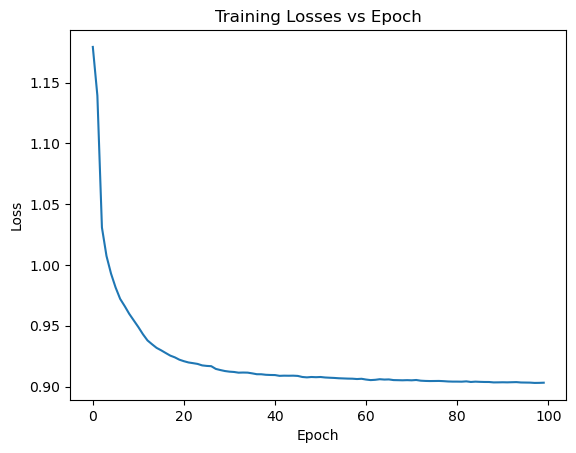

In [16]:
plt.title("Training Losses vs Epoch")
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

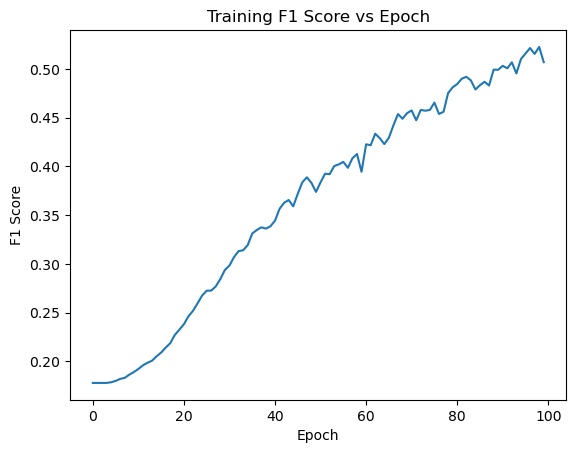

In [17]:
plt.title("Training F1 Score vs Epoch")
plt.plot(train_f1_scores)
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.show()

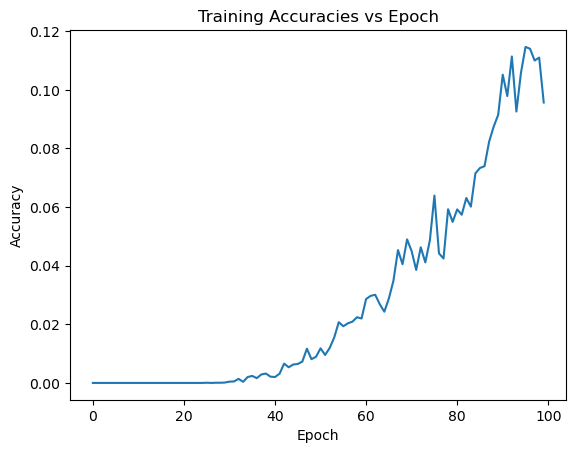

In [18]:
plt.title("Training Accuracies vs Epoch")
plt.plot(train_accs)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [19]:
test

NameError: name 'test' is not defined

In [ ]:
torch.save(model.state_dict(), '../lstm_2_token_64_256_19.pth')

In [ ]:
model = LSTM(
    no_layers=2,
    vocab_size=len(vocab), # extra 1 is already included, usually for padding
    embedding_dim=64,
    hidden_dim=256,
    output_dim=19,
)
model.load_state_dict(torch.load('../lstm_2_token_64_256_19.pth'))